<a href="https://colab.research.google.com/github/benedettacandelori/Monkeys_go_stop_trials/blob/main/Monkeys_earlier_predictions_move_onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import os
import math
import torch

In [ ]:
os.chdir('/content/drive/MyDrive')
os.getcwd() 

'/content/drive/MyDrive'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
%pip install pytorch_lightning einops seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchmetrics.classification import Accuracy, F1Score, MulticlassAccuracy
from torchmetrics.classification import BinaryAccuracy

# Dataset

### Dataset creation

In [ ]:
class Monkeys_dataset(Dataset):
    """Monkeys dataset"""

    def __init__(self, mat_file_labels, mat_file_x, root_dir, start_idx = 800, end_idx = 1200):
        """
        Args:
            mat_file (string): Path to the .mat files.
            root_dir (string): Directory with all the data.
        """
        self.classes = scipy.io.loadmat(mat_file_labels)['nostop']
        self.data = scipy.io.loadmat(mat_file_x)['matrix']
        self.root_dir = root_dir
        self.start_idx = start_idx
        self.end_idx = end_idx

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        x = self.data[:,idx,self.start_idx:self.end_idx]
        x = torch.tensor(x).float().squeeze(0)#.unsqueeze(1) 
        label = int(self.classes[idx,1])
      
        #sample = {'matrix': x, 'class': label}
        sample = (x, label)

        return sample

# Training function

In [ ]:
def train(model, train_dataset, val_dataset, batch_size = 8, num_epochs = 30, learning_rate = 0.0005):
  # Define loss function and optimizer
  
  criterion  = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # Define accuracy metric
  accuracy_metric = BinaryAccuracy()

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  
  # Train model
  for epoch in range(num_epochs):
  
    # Training
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        
        outputs = model(inputs)

        labels_onehot = F.one_hot(labels-1, num_classes=2)
        loss = criterion(outputs.float(), labels_onehot.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 

        classifications = torch.argmax(outputs, dim =1)
        #accuracy_metric.update(classifications, labels-1)
        acc = accuracy_metric(classifications, labels-1)
        train_acc += acc.item() 
              
                
    # Validation
    val_loss = 0.0
    val_acc = 0.0
    #accuracy_metric.reset()
    model.eval()
    with torch.no_grad():
      for inputs, labels in val_loader:
        # Forward pass
        
        outputs = model(inputs)
        
        labels_onehot = F.one_hot(labels-1, num_classes=2) 
        loss = criterion(outputs.float(), labels_onehot.float())

        val_loss += loss.item() 
        # Compute accuracy
        classifications = torch.argmax(outputs, dim =1)
        #accuracy_metric.update(classifications, labels-1)
        acc = accuracy_metric(classifications, labels-1)
        val_acc += acc.item() 

    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_loader)

    # Compute metrics
    train_loss = train_loss / len(train_loader)
   
    train_acc = train_acc / len(train_loader)
   
    #accuracy = accuracy_metric.compute()

    # Print results
    #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  
  return train_losses,train_accs, val_losses, val_accs


# Conv1D for validation - small
 

### CNN class 

In [ ]:
class Conv1DBinaryClassifier(nn.Module):
  def __init__(self):
    super(Conv1DBinaryClassifier, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=105, out_channels=64, kernel_size=5)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=8, kernel_size=5)
    self.pool = nn.MaxPool1d(kernel_size=2)
    
    self.fc1 = nn.Linear(in_features=8*97, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=2)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))
    #x = self.dropout(x)  
    x = self.pool(torch.relu(self.conv2(x))) 
    #x = self.dropout(x) 
    x = x.view(-1, 8*97)
    x = torch.relu(self.fc1(x))
    #x = self.dropout(x) 
    x = self.fc2(x)
    x = torch.sigmoid(x) 
    return x

### Experiments and results

In [ ]:
#HYPERPARAMS
bs = 32
n_epochs = 25
lr = 0.0005

In [ ]:
vecs_results = {
        'time session' : {'start' : [], 'end' : []},
        'train' : {'losses': [], 'accuracies': []},
        'val' : {'losses': [], 'accuracies': []}
    }
final_results = {
        'time session' : {'start' : [], 'end' : []},
        'train' : {'losses': [], 'accuracies': []},
        'val' : {'losses': [], 'accuracies': []}
    }


lag = np.arange(0,750,50)
start = 700
end = 1100
for idx, lag in enumerate(lag):
  
  print('Start training... for the time session: from ', start-lag,' to ',end-lag)

  dataset = Monkeys_dataset(mat_file_labels = 'Stop_Task_Collab_2023/BHV_Go.mat', mat_file_x = 'Stop_Task_Collab_2023/activity_movement_onset_Go.mat',
                                    root_dir='Stop_Task_Collab_2023/', start_idx = start-lag, end_idx = end-lag)
  monkey_train, monkey_val = torch.utils.data.random_split(dataset, [0.85, 0.15])
  
  model = Conv1DBinaryClassifier()



  train_losses, train_accs, val_losses, val_accs = train(model, monkey_train, monkey_val, batch_size = bs, num_epochs = n_epochs,  learning_rate = lr)

  vecs_results['time session']['start'].append(start-lag)
  vecs_results['time session']['end'].append(end-lag)
  final_results['time session']['start'].append(start-lag)
  final_results['time session']['end'].append(end-lag)

  vecs_results['train']['losses'].append(train_losses)
  vecs_results['train']['accuracies'].append(train_accs)
  vecs_results['val']['losses'].append(val_losses)
  vecs_results['val']['accuracies'].append(val_accs)

  final_results['train']['losses'].append(train_losses[-1])
  final_results['train']['accuracies'].append(train_accs[-1])
  final_results['val']['losses'].append(val_losses[-1])
  final_results['val']['accuracies'].append(val_accs[-1])

  print('Done')
  

In [ ]:
pickle_file_name = "b="+str(bs)+",ep="+str(n_epochs)+",lr="+str(lr)+".pkl"

In [ ]:
#SAVE
import pickle

f = open(pickle_file_name,"wb")
pickle.dump(final_results,f)
f.close()

f = open("complete_version: "+pickle_file_name,"wb")
pickle.dump(vecs_results,f)
f.close()

In [ ]:
#LOAD
import pickle

f = open(pickle_file_name,"rb")
final_results = pickle.load(f)
f.close()

f = open("complete_version: "+pickle_file_name,"rb")
vecs_results = pickle.load(f)
f.close()

In [ ]:
x_labs = []
for i in range(len(final_results['time session']['start'])):
  x_labs.append(str(final_results['time session']['start'][i])+'-'+str(final_results['time session']['end'][i]))

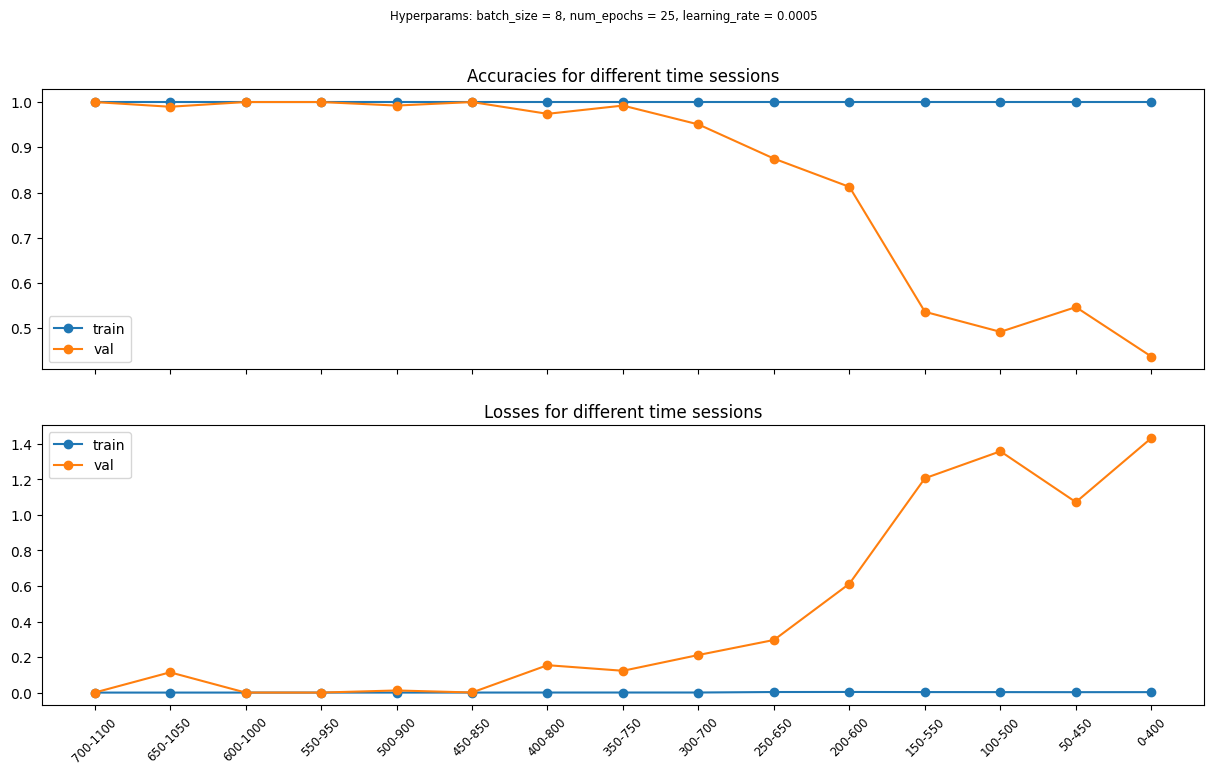

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(2, 1, 1)
plt.plot(x_labs,final_results['train']['accuracies'], label = 'train', marker = 'o' )
plt.plot(x_labs,final_results['val']['accuracies'], label = 'val', marker = 'o')
plt.xticks(rotation = 45, size = 'small',color = 'white')
plt.legend()
plt.title('Accuracies for different time sessions')

plt.subplot(2, 1, 2)
plt.plot(x_labs,final_results['train']['losses'], label = 'train', marker = 'o')
plt.plot(x_labs,final_results['val']['losses'], label = 'val', marker = 'o')
plt.xticks(rotation = 45, size = 'small')
plt.legend()
plt.title('Losses for different time sessions')
plt.suptitle('Hyperparams: batch_size = 8, num_epochs = 25, learning_rate = 0.0005', fontsize = 'small')

plt.show()

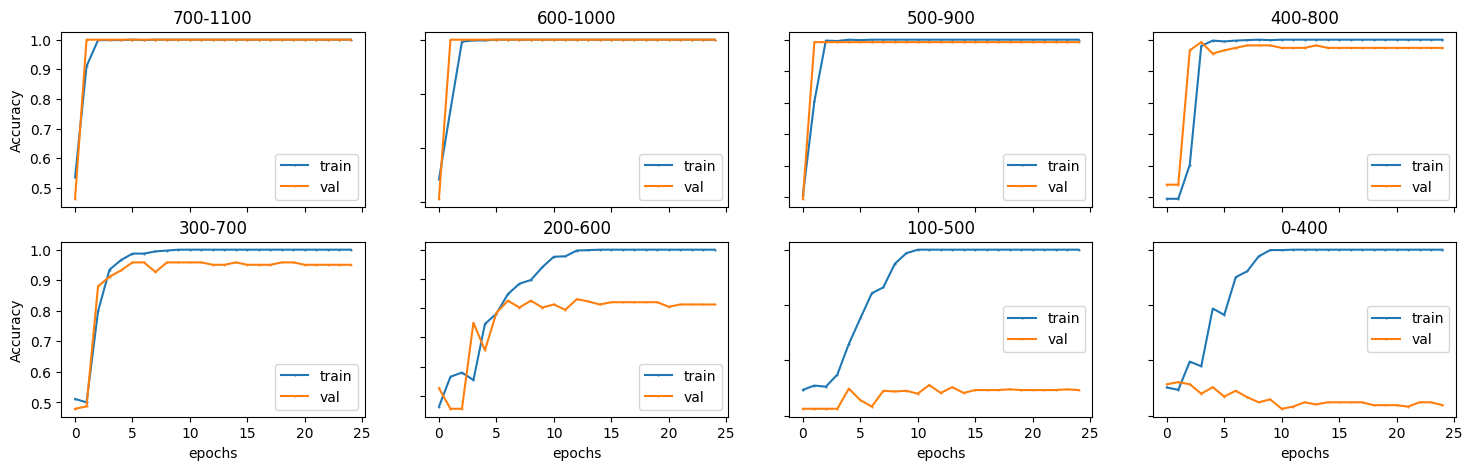

In [ ]:

fig, axs = plt.subplots(2, 4, figsize=(18, 5))

idx = 0
for i in range(2):
  for j in range(4):

    axs[i, j].plot(vecs_results['train']['accuracies'][idx], label = 'train', marker = 'o' ,markersize = 0.5)
    axs[i, j].plot(vecs_results['val']['accuracies'][idx], label = 'val', marker = 'o',markersize = 0.5)
    axs[i, j].set_title(str(vecs_results['time session']['start'][idx])+'-'+str(vecs_results['time session']['end'][idx]))
    axs[i, j].legend()
    idx += 2
for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

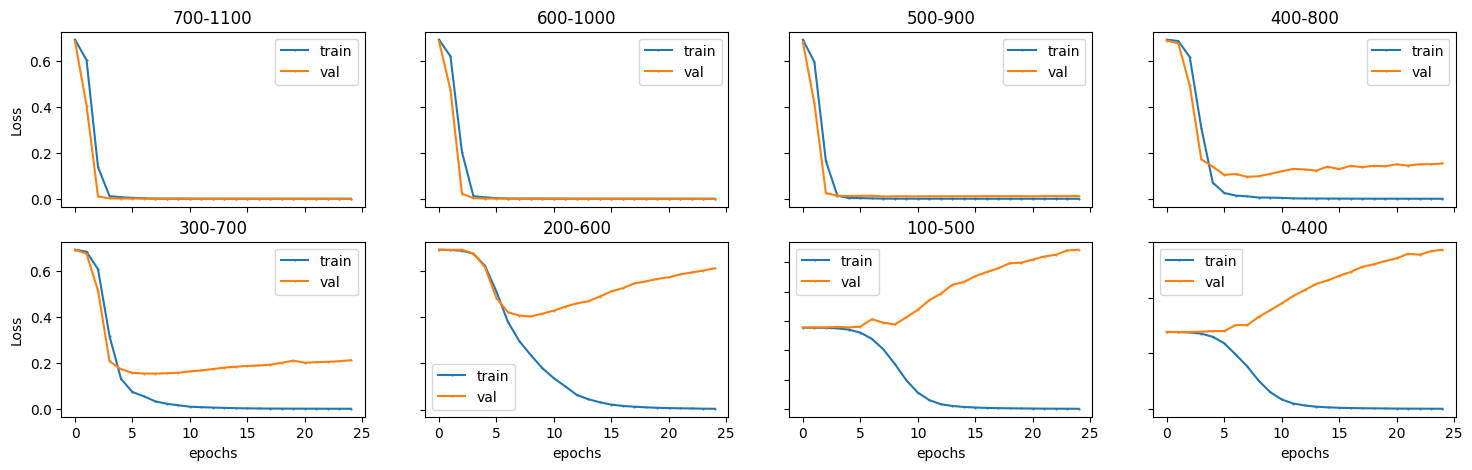

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(18, 5))

idx = 0
for i in range(2):
  for j in range(4):

    axs[i, j].plot(vecs_results['train']['losses'][idx], label = 'train', marker = 'o' ,markersize = 0.5)
    axs[i, j].plot(vecs_results['val']['losses'][idx], label = 'val', marker = 'o',markersize = 0.5)
    axs[i, j].set_title(str(vecs_results['time session']['start'][idx])+'-'+str(vecs_results['time session']['end'][idx]))
    axs[i, j].legend()
    idx += 2
for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='Loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# Conv1D for validation - large


### CNN class 

In [ ]:
class Conv1DBinaryClassifier_large(nn.Module):
  def __init__(self):
    super(Conv1DBinaryClassifier_large, self).__init__()

    # Define the layers of the network
    self.conv1 = nn.Conv1d(in_channels=105, out_channels=32, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool1d(kernel_size=2)
    self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.dconv1 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=2, dilation=2)
    self.pool2 = nn.MaxPool1d(kernel_size=2)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.dconv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=4, dilation=4)
    self.pool3 = nn.MaxPool1d(kernel_size=2)
    
    #self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv4 = nn.Conv1d(in_channels=128, out_channels=8, kernel_size=3, padding=1)
    self.dconv3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=8, dilation=8)
    self.pool4 = nn.MaxPool1d(kernel_size=2)
    
    self.fc1 = nn.Linear(50 * 8, 128)
    self.fc2 = nn.Linear(128, 2) 
    self.dropout = nn.Dropout(p=0.5)
    
  def forward(self, x):
    # Apply the layers in the forward pass

    x = self.pool1(torch.relu(self.conv1(x)))
    x = torch.relu(self.conv2(x))
    x = self.pool2(torch.relu(self.dconv1(x)))
    #x = self.pool3(torch.relu(self.conv3(x)))
    x = torch.relu(self.conv3(x))
    x = self.pool3(torch.relu(self.dconv2(x)))
    x = torch.relu(self.conv4(x))
    #x = self.pool4(torch.relu(self.dconv3(x)))
    x = x.view(-1, 50 * 8)
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    x = torch.sigmoid(x) 
    return x

### Experiments and results

**Possible hyperparameters**

batch size = 4, 8, 16, 32

number of epochs = 25

learning rate = 0.001, 0.0005

In [ ]:
#HYPERPARAMS

bs = 32
n_epochs = 70
lr = 0.00001

In [ ]:


lag = np.arange(0,250,50)
start = 550
end = 950

for idx, lag in enumerate(lag):
  print(start-lag,'---', end-lag)

550 --- 950
500 --- 900
450 --- 850
400 --- 800
350 --- 750


In [ ]:
vecs_results = {
        'time session' : {'start' : [], 'end' : []},
        'train' : {'losses': [], 'accuracies': []},
        'val' : {'losses': [], 'accuracies': []}
    }
final_results = {
        'time session' : {'start' : [], 'end' : []},
        'train' : {'losses': [], 'accuracies': []},
        'val' : {'losses': [], 'accuracies': []}
    }


lag = np.arange(0,250,50)
start = 550
end = 950
for idx, lag in enumerate(lag):
  
  print('Start training... for the time session: from ', start-lag,' to ',end-lag)

  dataset = Monkeys_dataset(mat_file_labels = 'Stop_Task_Collab_2023/BHV_Go.mat', mat_file_x = 'Stop_Task_Collab_2023/activity_movement_onset_Go.mat',
                                    root_dir='Stop_Task_Collab_2023/', start_idx = start-lag, end_idx = end-lag)
  monkey_train, monkey_val = torch.utils.data.random_split(dataset, [0.85, 0.15])
  
  model = Conv1DBinaryClassifier_large()



  train_losses, train_accs, val_losses, val_accs = train(model, monkey_train, monkey_val, batch_size = bs, num_epochs = n_epochs,  learning_rate = lr)

  vecs_results['time session']['start'].append(start-lag)
  vecs_results['time session']['end'].append(end-lag)
  final_results['time session']['start'].append(start-lag)
  final_results['time session']['end'].append(end-lag)

  vecs_results['train']['losses'].append(train_losses)
  vecs_results['train']['accuracies'].append(train_accs)
  vecs_results['val']['losses'].append(val_losses)
  vecs_results['val']['accuracies'].append(val_accs)

  final_results['train']['losses'].append(train_losses[-1])
  final_results['train']['accuracies'].append(train_accs[-1])
  final_results['val']['losses'].append(val_losses[-1])
  final_results['val']['accuracies'].append(val_accs[-1])

  print('Done')
  

Start training... for the time session: from  550  to  950
Done
Start training... for the time session: from  500  to  900
Done
Start training... for the time session: from  450  to  850
Done
Start training... for the time session: from  400  to  800
Done
Start training... for the time session: from  350  to  750
Done


In [ ]:
pickle_file_name = "b="+str(bs)+",ep="+str(n_epochs)+",lr="+str(lr)+"_large.pkl"

In [ ]:
#SAVE
import pickle

f = open(pickle_file_name,"wb")
pickle.dump(final_results,f)
f.close()

f = open("complete_version: "+pickle_file_name,"wb")
pickle.dump(vecs_results,f)
f.close()

In [ ]:
#LOAD
import pickle

f = open(pickle_file_name,"rb")
final_results = pickle.load(f)
f.close()

f = open("complete_version: "+pickle_file_name,"rb")
vecs_results = pickle.load(f)
f.close()

In [ ]:
x_labs = []
for i in range(len(final_results['time session']['start'])):
  x_labs.append(str(final_results['time session']['start'][i])+'-'+str(final_results['time session']['end'][i]))

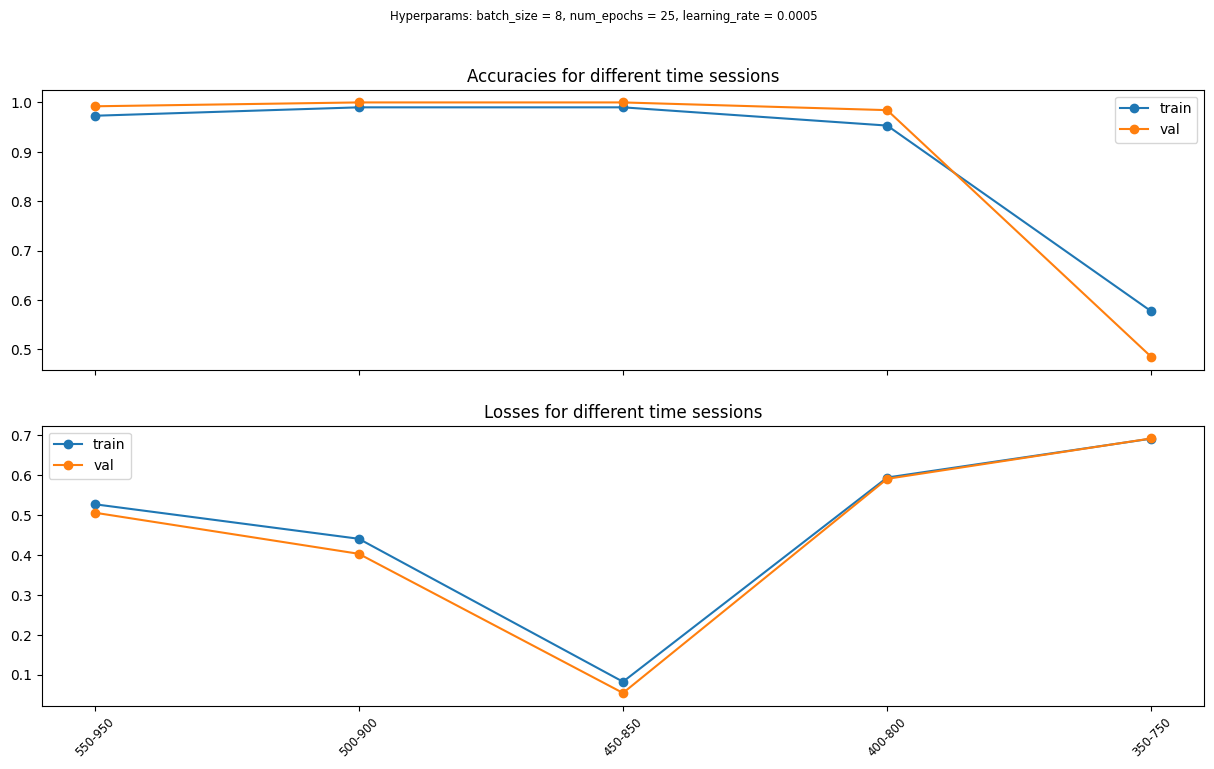

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(2, 1, 1)
plt.plot(x_labs,final_results['train']['accuracies'], label = 'train', marker = 'o' )
plt.plot(x_labs,final_results['val']['accuracies'], label = 'val', marker = 'o')
plt.xticks(rotation = 45, size = 'small',color = 'white')
plt.legend()
plt.title('Accuracies for different time sessions')

plt.subplot(2, 1, 2)
plt.plot(x_labs,final_results['train']['losses'], label = 'train', marker = 'o')
plt.plot(x_labs,final_results['val']['losses'], label = 'val', marker = 'o')
plt.xticks(rotation = 45, size = 'small')
plt.legend()
plt.title('Losses for different time sessions')
plt.suptitle('Hyperparams: batch_size = 8, num_epochs = 25, learning_rate = 0.0005', fontsize = 'small')

plt.show()

IndexError: ignored

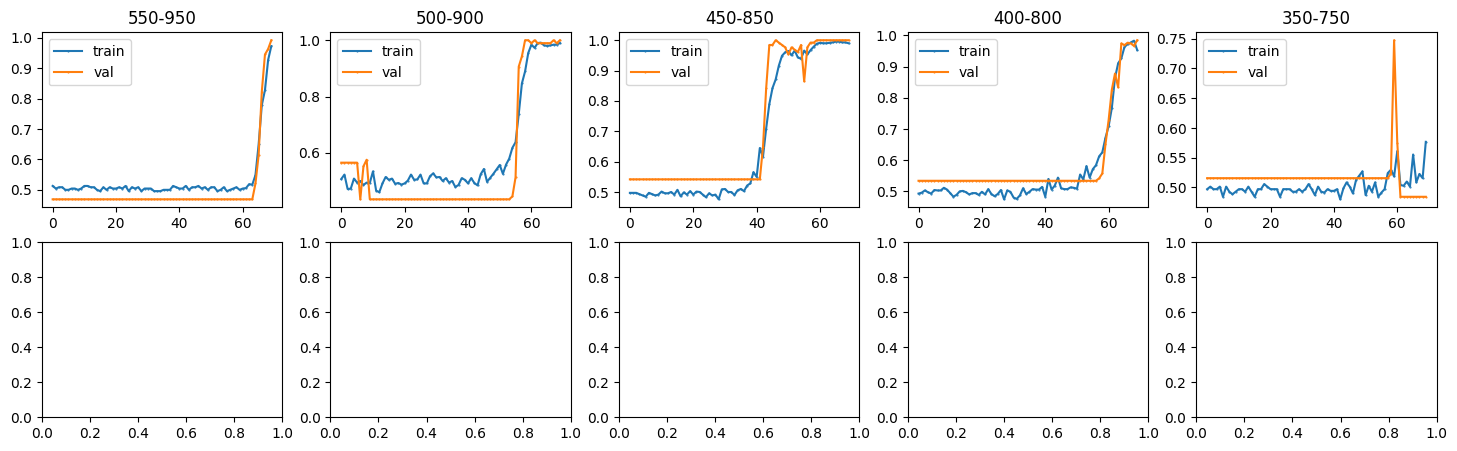

In [ ]:

fig, axs = plt.subplots(2, 5, figsize=(18, 5))

idx = 0
for i in range(2):
  for j in range(5):

    axs[i, j].plot(vecs_results['train']['accuracies'][idx], label = 'train', marker = 'o' ,markersize = 0.5)
    axs[i, j].plot(vecs_results['val']['accuracies'][idx], label = 'val', marker = 'o',markersize = 0.5)
    axs[i, j].set_title(str(vecs_results['time session']['start'][idx])+'-'+str(vecs_results['time session']['end'][idx]))
    axs[i, j].legend()
    idx += 1
for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

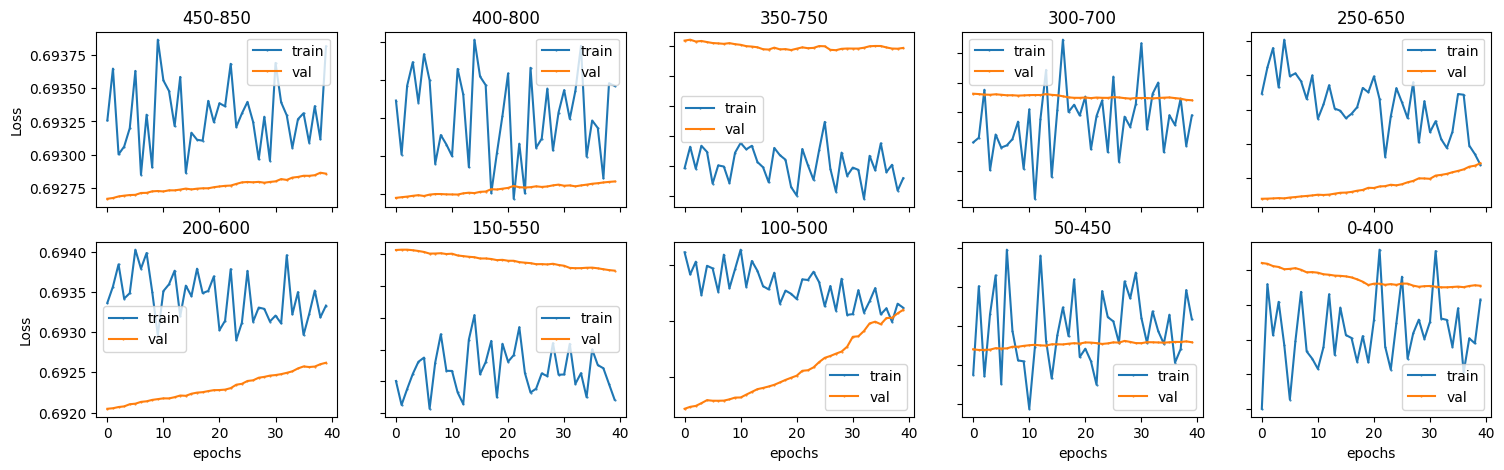

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(18, 5))

idx = 0
for i in range(2):
  for j in range(5):

    axs[i, j].plot(vecs_results['train']['losses'][idx], label = 'train', marker = 'o' ,markersize = 0.5)
    axs[i, j].plot(vecs_results['val']['losses'][idx], label = 'val', marker = 'o',markersize = 0.5)
    axs[i, j].set_title(str(vecs_results['time session']['start'][idx])+'-'+str(vecs_results['time session']['end'][idx]))
    axs[i, j].legend()
    idx += 1
for ax in axs.flat:
    ax.set(xlabel='epochs', ylabel='Loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()